# Feature Relevance

Trying to find out what the most relevant features are, for the ones we can't understan basd on "naked eye analysis"

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression  
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


from py_helpers.db_helper import retrieve_data

In [2]:
database_name="./db/WNBA_filtered.db"
table_name='Teams'
df = retrieve_data(database_name, table_name)

In [3]:
all_features = ['o_fgm','o_fga','o_ftm','o_fta','o_3pm','o_3pa','o_oreb','o_dreb','o_reb','o_asts','o_pf','o_stl','o_to','o_blk','o_pts','d_fgm','d_fga','d_ftm','d_fta','d_3pm','d_3pa','d_oreb','d_dreb','d_reb','d_asts','d_pf','d_stl','d_to','d_blk','d_pts']

o_features = ['o_fgm','o_fga','o_ftm','o_fta','o_3pm','o_3pa','o_oreb','o_dreb','o_reb','o_asts','o_pf','o_stl','o_to','o_blk','o_pts']

d_features = ['d_fgm','d_fga','d_ftm','d_fta','d_3pm','d_3pa','d_oreb','d_dreb','d_reb','d_asts','d_pf','d_stl','d_to','d_blk','d_pts']


# Separating out the features
x = df.loc[:, all_features].values

# # Separating out the target
y = df.loc[:, ['playoff']].values.ravel()

In [4]:
scaler = StandardScaler()
x = scaler.fit_transform(x)

---
## Recursive Feature Elimination

In [5]:
estimator = LogisticRegression()  
selector = RFE(estimator, n_features_to_select=3)  
selector = selector.fit(x, y)

selected_features = selector.support_
rfe_relevant_features = []
for feature_index, is_selected in enumerate(selected_features):
    if is_selected:
        rfe_relevant_features.append(all_features[feature_index])

rfe_relevant_features

['o_fgm', 'o_pts', 'd_pts']

These are the most relevant features, from the specified list, which means that after recursively traversing them all, these apear to be the most impactful.

---
# PCA 

After discovering the most relevant features, we can reduce dimensionality even further

In [6]:
x = df.loc[:, rfe_relevant_features].values

y = df.loc[:, ['playoff']].values.ravel()

x = StandardScaler().fit_transform(x)

In [7]:
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x)

explained_variance = pca.explained_variance_ratio_
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [8]:
finalDf = pd.concat([principalDf, df[['playoff']]], axis = 1)

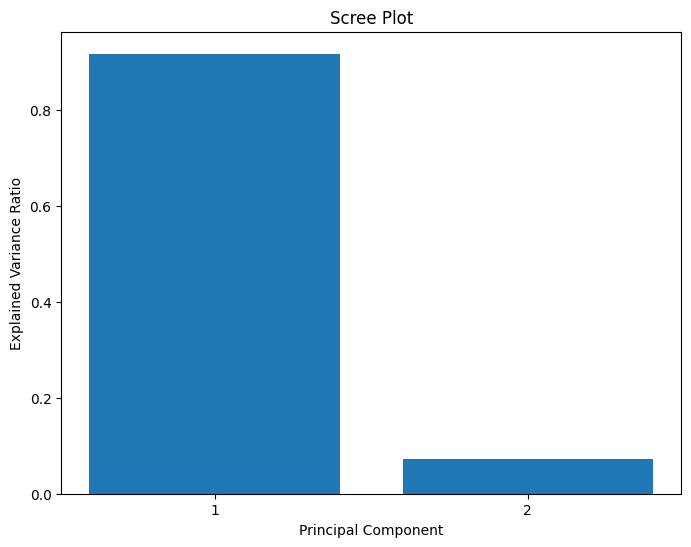

In [9]:
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, align='center', label='Variance Ratio')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.xticks(np.arange(1, len(explained_variance) + 1))
plt.show()

In [10]:
explained_variance

array([0.91650537, 0.07267194])

PCA3: array([0.91650537, 0.07267194, 0.01082269])

PCA2: array([0.91650537, 0.07267194]) -> we keep and use this one

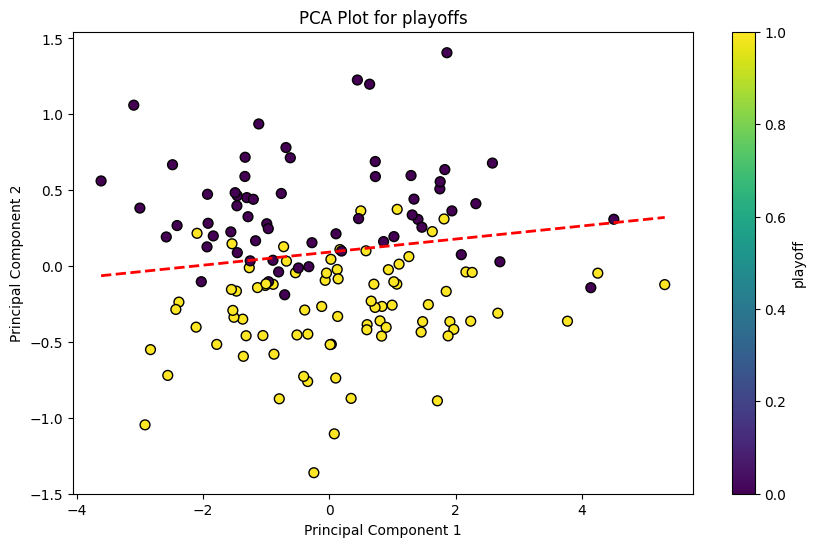

In [11]:

X = finalDf[['principal component 1', 'principal component 2']]
y = finalDf['playoff']

model = LogisticRegression()
model.fit(X, y)

plt.figure(figsize=(10, 6))
plt.scatter(finalDf['principal component 1'], finalDf['principal component 2'], c=finalDf['playoff'], cmap='viridis', edgecolor='k', s=50)
plt.colorbar(label='playoff')

coefficients = model.coef_
intercept = model.intercept_
x_values = np.linspace(finalDf['principal component 1'].min(), finalDf['principal component 1'].max(), num=100)
y_values = (-coefficients[0, 0] / coefficients[0, 1]) * x_values - (intercept / coefficients[0, 1])
plt.plot(x_values, y_values, color='red', linestyle='--', linewidth=2)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Plot for playoffs')
plt.show()


In [12]:
principalDf.head()

,principal component 1,principal component 2
0,1.863011,1.406214
1,3.771657,-0.363841
2,-0.616369,0.713496
3,-2.380180,-0.237982
4,-1.469407,-0.165623
